# Step 1: EDA 

In [69]:
# Imports & Setup:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn import metrics
from tensorflow.keras.models import Sequential
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


In [3]:
# function to load in and process images
def load_image(path):
    images = Image.open(f'./../CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

In [82]:
class_map_dir= pd.read_csv('Tables/class_map_taxonomy_directory.csv')
class_map_dir.head(5)

Image Id                                         Image Name  \
0         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
1         2  001.Black_footed_Albatross/Black_Footed_Albatr...   
2         3  001.Black_footed_Albatross/Black_Footed_Albatr...   
3         4  001.Black_footed_Albatross/Black_Footed_Albatr...   
4         5  001.Black_footed_Albatross/Black_Footed_Albatr...   

   Is Training Image  Class Id                  Class Name              Order  \
0                  0         1  001.Black_footed_Albatross  PROCELLARIIFORMES   
1                  1         1  001.Black_footed_Albatross  PROCELLARIIFORMES   
2                  0         1  001.Black_footed_Albatross  PROCELLARIIFORMES   
3                  1         1  001.Black_footed_Albatross  PROCELLARIIFORMES   
4                  1         1  001.Black_footed_Albatross  PROCELLARIIFORMES   

   Order_Num_Seq      Species  Species_Num_Seq       Family  Family_Num_Seq  
0             11  Albatrosses                1  Diomedeidae              11  
1             11  Albatrosses                1  Diomedeidae              11  
2             11  Albatrosses                1  Diomedeidae              11  
3             11  Albatrosses                1  Diomedeidae              11  
4             11  Albatrosses                1  Diomedeidae              11

In [83]:
class_map_dir.dtypes

Image Id              int64
Image Name           object
Is Training Image     int64
Class Id              int64
Class Name           object
Order                object
Order_Num_Seq         int64
Species              object
Species_Num_Seq       int64
Family               object
Family_Num_Seq        int64
dtype: object

In [84]:
# Main Directory Files

images= pd.read_csv("./../CUB_200_2011/images.txt", sep=" ", header=None, names=['image_id','image_name'])
train_test_list= pd.read_csv("./../CUB_200_2011/train_test_split.txt", sep=" ", header=None, names=['image_id','is_training_image'])
classes= pd.read_csv("./../CUB_200_2011/classes.txt", sep=" ", header=None, names=['class_id', 'class_name'])
image_class_labels= pd.read_csv("./../CUB_200_2011/image_class_labels.txt", sep=" ", header=None, names=['image_id', 'class_id'])
bounding_boxes= pd.read_csv("./../CUB_200_2011/bounding_boxes.txt", sep=" ", header=None, names=['image_id','x','y','width','height'])

In [85]:
# Parts Directory Files 

parts= pd.read_csv("./../CUB_200_2011/parts/parts_edited.txt", sep=" ", header=None, names=['part_id','part_name'])
# Part Locs Note: <x> and <y> denote the pixel location of the center of the part.
part_locs= pd.read_csv("./../CUB_200_2011/parts/part_locs.txt", sep=" ", header=None, names=['image_id', 'part_id', 'x','y','visible'])
part_click_locs= pd.read_csv("./../CUB_200_2011/parts/part_click_locs.txt", sep=" ", header=None, names=['image_id', 'part_id', 'x','y','visible','time'])

In [86]:
# Attributes Directory Files 

attributes= pd.read_csv("./../CUB_200_2011/attributes/attributes.txt", sep=" ", header=None, names=['attribute_id','attribute_name'])
certainties= pd.read_csv("./../CUB_200_2011/attributes/certainties.txt", sep=" ", header=None, names=['certainty_id','certainty_name'])
image_attribute_labels= pd.read_csv("./../CUB_200_2011/attributes/image_attribute_labels.txt", sep=" ", header=None, names=['image_id','attribute_id','is_present','certainty_id','time'])
class_attribute_labels_continuous= pd.read_csv("./../CUB_200_2011/attributes/class_attribute_labels_continuous.txt", sep=" ", header=None)
# each line corresponds to one class (in the same order as classes)

In [87]:
# View table of heirarchy, sorted by % of total (top 10 most frequent)
class_map_dir['Family ']=class_map_dir['Species']+" ~ "+class_map_dir['Family']
# View table of heirarchy, sorted by % of total (top 10 most frequent)
df3 = class_map_dir.groupby(['Order', 'Family ']).size().reset_index()
df3.columns = ['Order','Family', 'Images']
df3['% of Total'] = round((df3['Images'] / df3['Images'].sum()) * 100,2)
df3.sort_values(['% of Total'], ascending=False ).head(10)

Order                                          Family  Images  \
15    PASSERIFORMES                  New World Warblers ~ Parulidae    1790   
14    PASSERIFORMES              New World Sparrows ~ Passerellidae    1424   
4   CHARADRIIFORMES                Gulls, Terns, Skimmers ~ Laridae     940   
21    PASSERIFORMES                Troupials and Allies ~ Icteridae     774   
22    PASSERIFORMES                 Tyrant Flycatchers ~ Tyrannidae     656   
10    PASSERIFORMES                 Crows, Jays, Magpies ~ Corvidae     476   
9     PASSERIFORMES                Cardinals, Allies ~ Cardinalidae     473   
26    PASSERIFORMES                           Wrens ~ Troglodytidae     419   
23    PASSERIFORMES  Vireos, Shrike-Babblers, Erpornis ~ Vireonidae     409   
29       PICIFORMES                           Woodpeckers ~ Picidae     408   

    % of Total  
15       15.18  
14       12.08  
4         7.97  
21        6.57  
22        5.56  
10        4.04  
9         4.01  
26        3.55  
23        3.47  
29        3.46

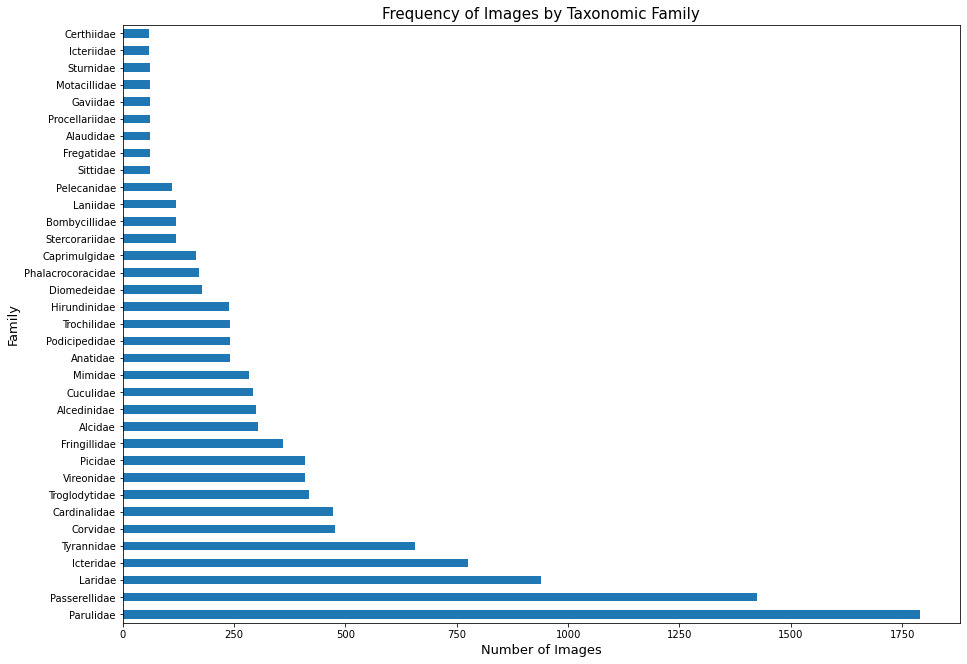

In [94]:
# view frequency of family classifications (35)
class_map_dir['Family'].value_counts().plot(kind='barh', figsize=(15,11))
# Set title
plt.title('Frequency of Images by Taxonomic Family', fontsize = 15)
plt.xlabel('Number of Images', fontsize = 13)
plt.ylabel('Family', fontsize = 13);
plt.savefig('Visualizations/family_hist.png')

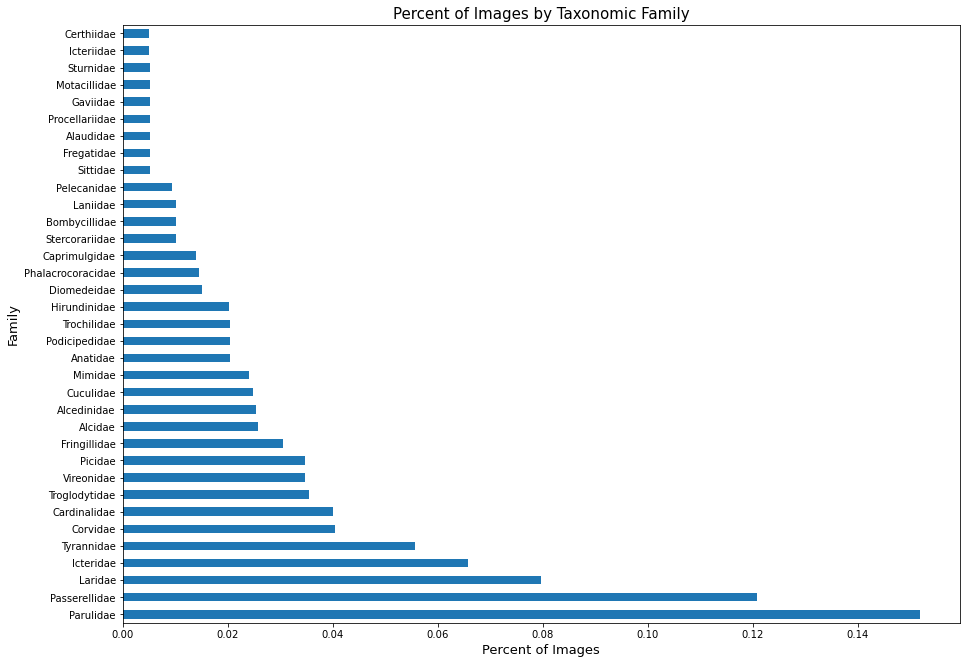

In [97]:
# view % frequency of family classifications (35)
class_map_dir['Family'].value_counts(normalize=True).plot(kind='barh', figsize=(15,11))
# Set title
plt.title('Percent of Images by Taxonomic Family', fontsize = 15)
plt.xlabel('Percent of Images', fontsize = 13)
plt.ylabel('Family', fontsize = 13);

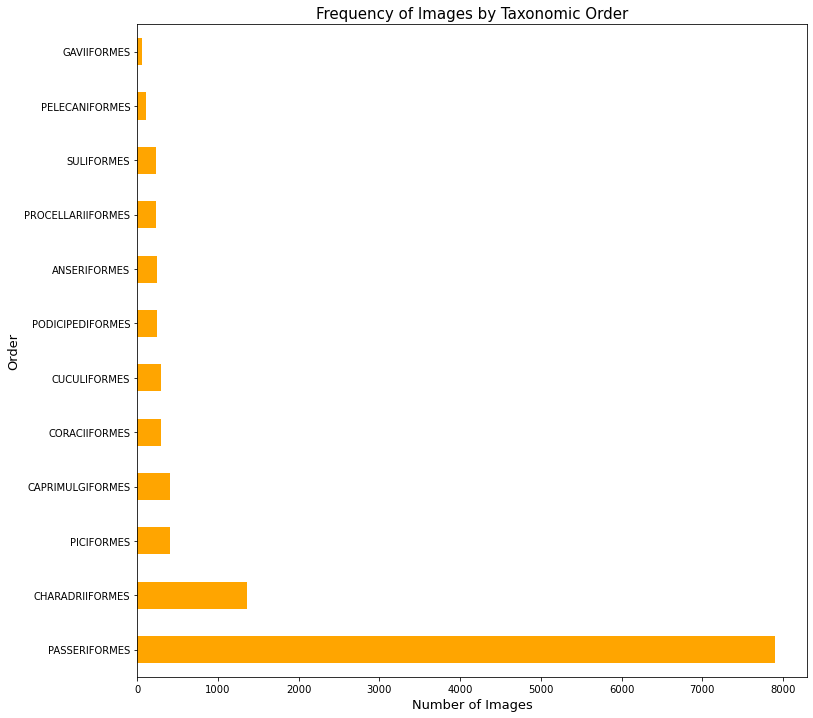

In [96]:
# view frequency of order classifications (12)
class_map_dir['Order'].value_counts().plot(kind='barh', figsize=(12,12), color='orange');
# Set title
plt.title('Frequency of Images by Taxonomic Order', fontsize = 15)
plt.xlabel('Number of Images', fontsize = 13)
plt.ylabel('Order', fontsize = 13)
plt.savefig('Visualizations/order_hist.png');

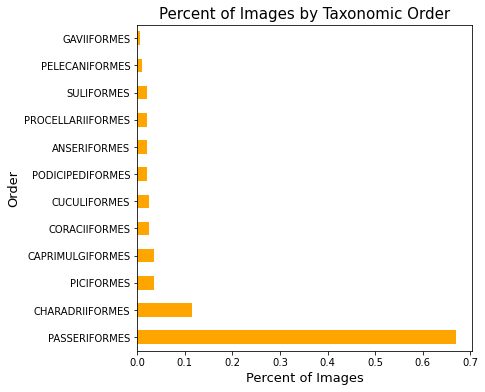

In [91]:
# view % frequency of order classifications (12)
class_map_dir['Order'].value_counts(normalize=True).plot(kind='barh', figsize=(6,6), color='orange');
# Set title
plt.title('Percent of Images by Taxonomic Order', fontsize = 15)
plt.xlabel('Percent of Images', fontsize = 13)
plt.ylabel('Order', fontsize = 13);

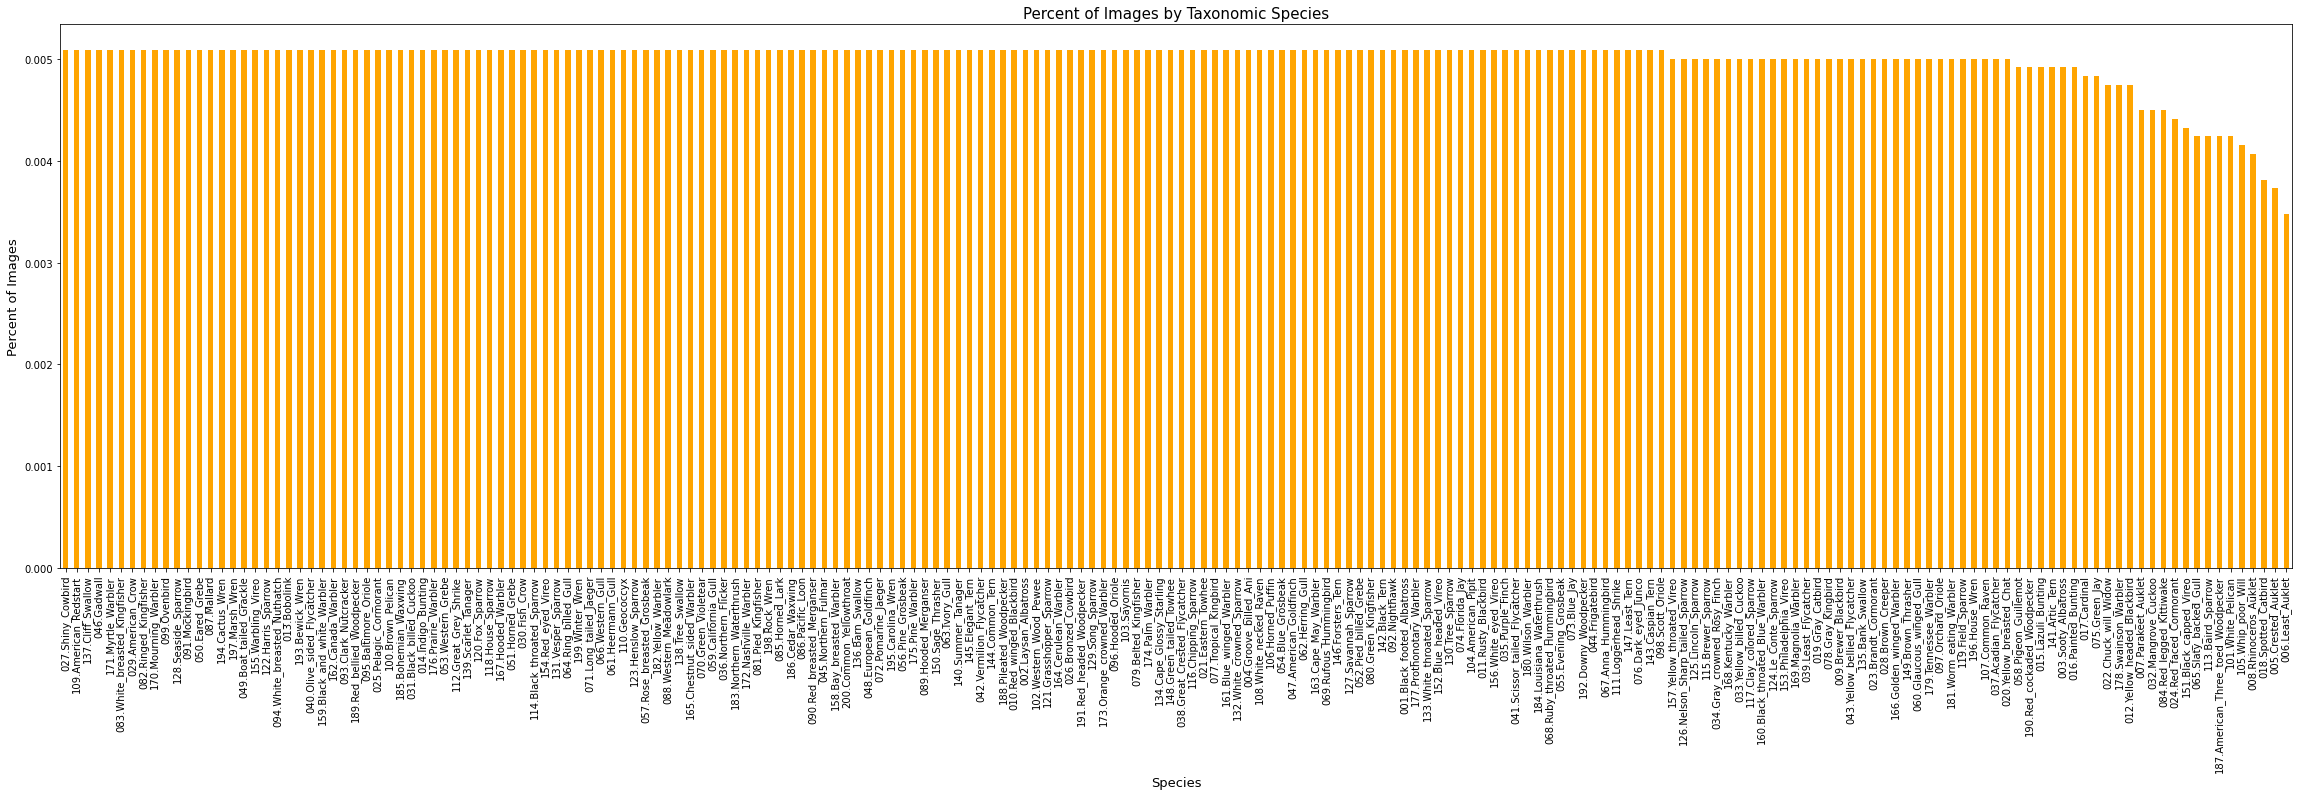

In [92]:
# view % frequency of order classifications (200)
class_map_dir['Class Name'].value_counts(normalize=True).plot(kind='bar', figsize=(40,10), color='orange');
# Set title
plt.title('Percent of Images by Taxonomic Species', fontsize = 15)
plt.xlabel('Species', fontsize = 13)
plt.ylabel('Percent of Images', fontsize = 13);

## Establish Baseline Accuracies

In [33]:
#Find baseline accuracy for order (majority class)
class_map_dir['Order'].value_counts(normalize=True).head(1)

PASSERIFORMES    0.670173
Name: Order, dtype: float64

In [36]:
#Find baseline accuracy for family (majority class)
class_map_dir['Family'].value_counts(normalize=True).head(1)

Parulidae    0.151849
Name: Family, dtype: float64

In [42]:
#Find baseline accuracy for species (All groups have the same size (1/200) classes)
class_map_dir['Class Id'].value_counts(normalize=True).head(1)

4    0.00509
Name: Class Id, dtype: float64

## View Subset of Images from Classes

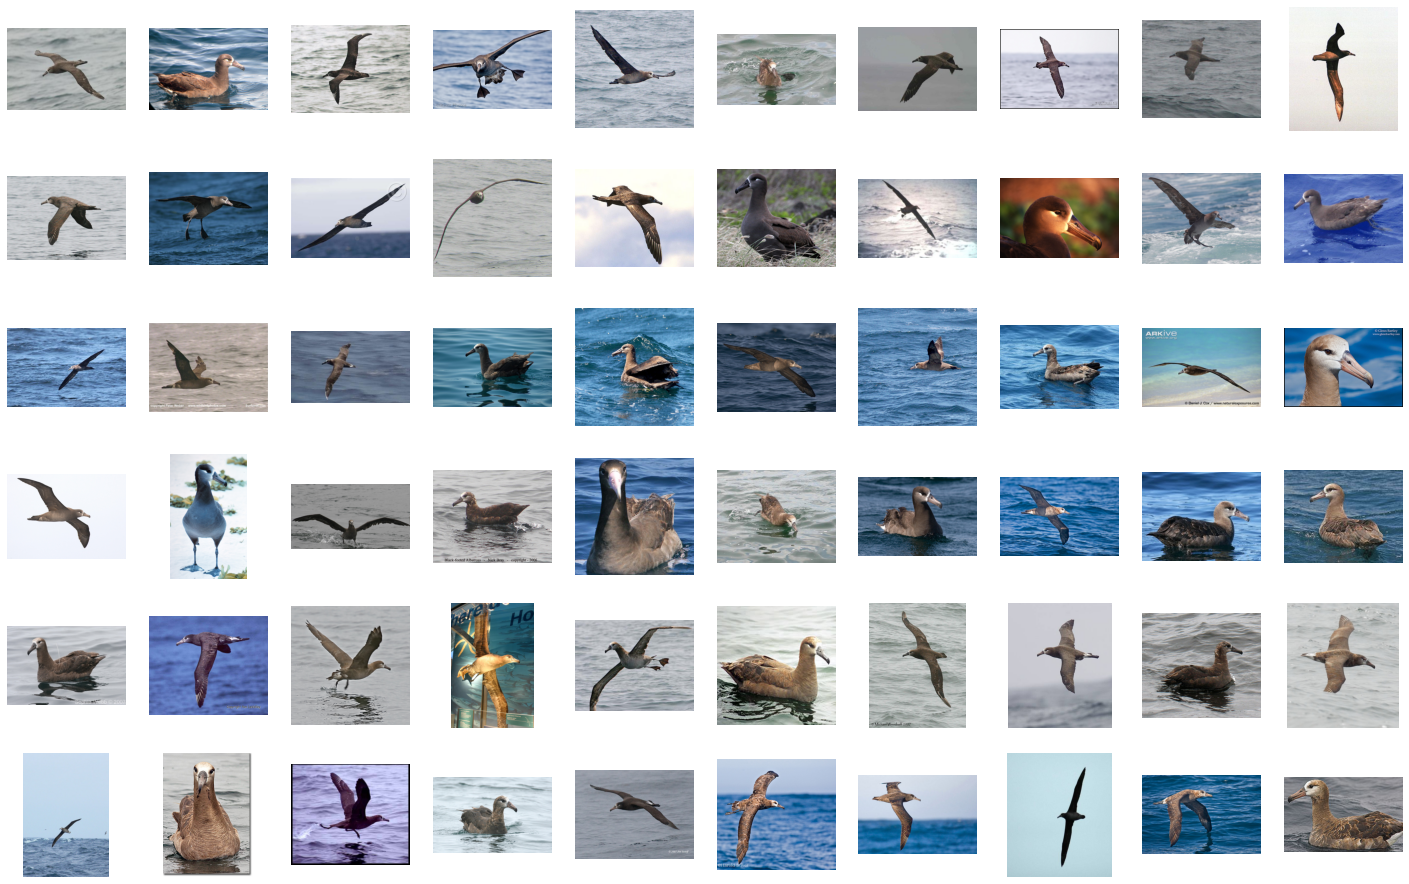

In [16]:
#Example of Black Footed Albatross Class
src = './../CUB_200_2011/images/001.Black_footed_Albatross/' # Images source

files = os.listdir(src) # Getting the files to copy

fig, axs = plt.subplots(6, 10, figsize=(25, 16))
axs_flat = axs.flatten()
for idx, image_src in enumerate(files):
  #  fig, ax = plt.subplots(figsize=(20, 20))
    image = Image.open(f'{src}{image_src}')  
  #  plt.figure(figsize=(30,30))
    axs_flat[idx].imshow(image)
    axs_flat[idx].axis('off')
    #plt.subplot(6, 10, idx+1), plt.imshow(image) #6 x 10 because there are 60 images

#fig, ax = plt.subplots(figsize=(20, 20))
#plt.figure(figsize=(30, 30))
#plt.subplots(figsize=(20, 20))
plt.show()

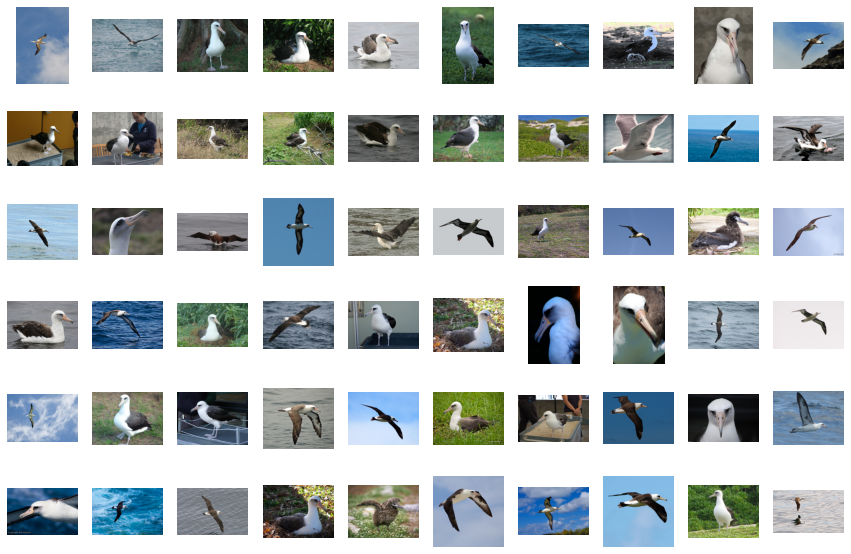

In [17]:
#Example of Laysan Albatross Class
src = './../CUB_200_2011/images/002.Laysan_Albatross/' # Images source

files = os.listdir(src) # Getting the files to copy

fig, axs = plt.subplots(6, 10, figsize=(15, 10))
axs_flat = axs.flatten()
for idx, image_src in enumerate(files):
    image = Image.open(f'{src}{image_src}')  
    axs_flat[idx].imshow(image)
    axs_flat[idx].axis('off')

plt.show()

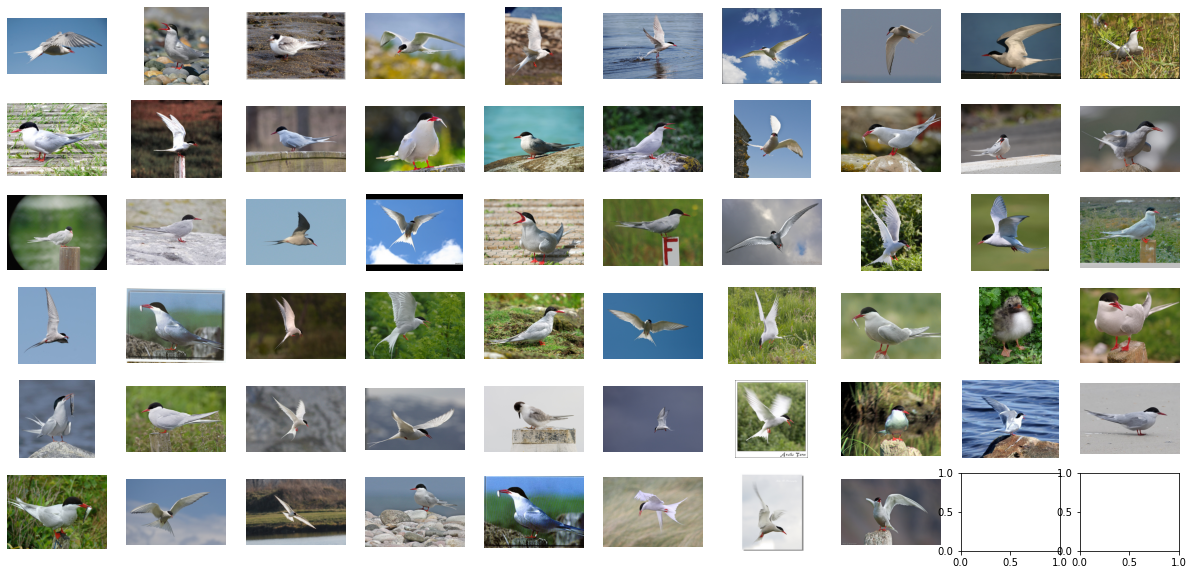

In [15]:
#Example of Artic Tern
src = './../CUB_200_2011/images/141.Artic_Tern/' # Images source

files = os.listdir(src) # Getting the files to copy

fig, axs = plt.subplots(6, 10, figsize=(21, 10))
axs_flat = axs.flatten()
for idx, image_src in enumerate(files):
    image = Image.open(f'{src}{image_src}')  
    axs_flat[idx].imshow(image)
    axs_flat[idx].axis('off')

plt.show()

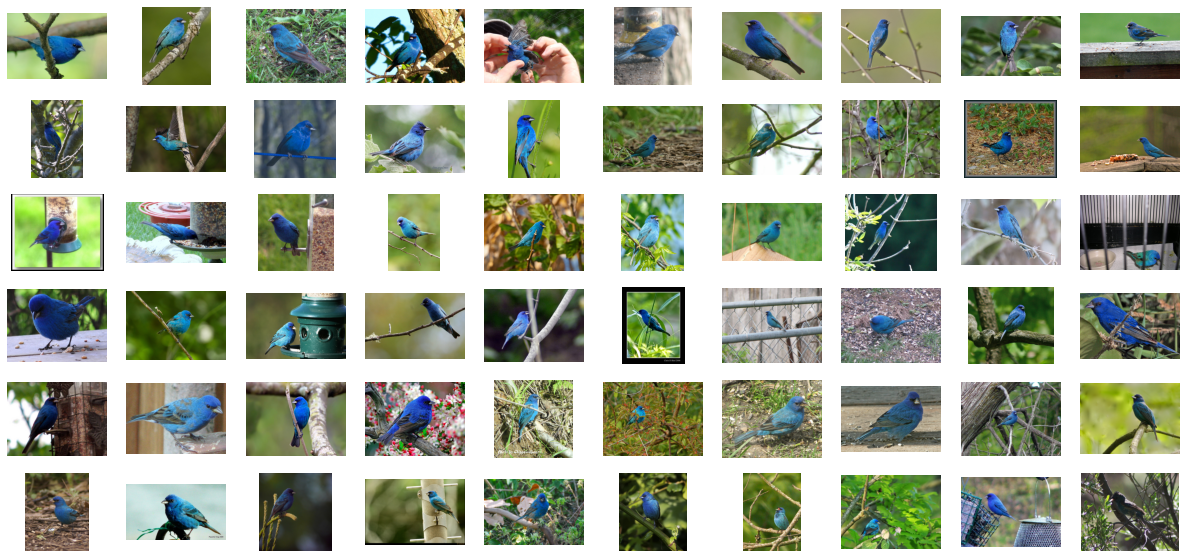

In [13]:
#Example of Indigo Bunting
src = './../CUB_200_2011/images/014.Indigo_Bunting/' # Images source

files = os.listdir(src) # Getting the files to copy

fig, axs = plt.subplots(6, 10, figsize=(21, 10))
axs_flat = axs.flatten()
for idx, image_src in enumerate(files):
    image = Image.open(f'{src}{image_src}')  
    axs_flat[idx].imshow(image)
    axs_flat[idx].axis('off')

plt.show()

## Explore Data Augmentation

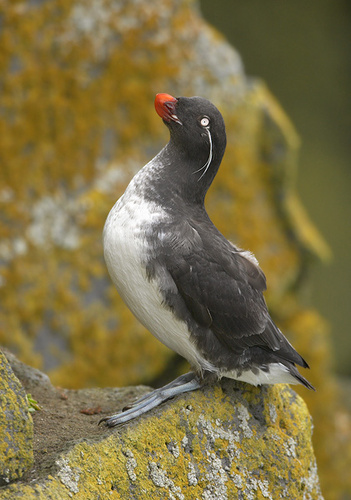

In [54]:
#Test image
image_test = Image.open("./../CUB_200_2011/images/007.Parakeet_Auklet/Parakeet_Auklet_0064_795954.jpg")
image_test2 = np.asarray(image_test)
ex2=np.array(image_test2)
pilImage_flipped = Image.fromarray(ex2)
pilImage_flipped

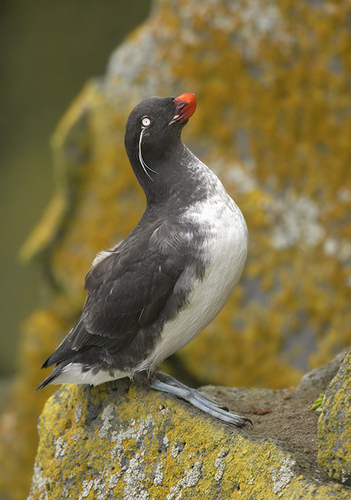

In [55]:
# Flip the test image 
def flip_image(i):
    return tf.image.flip_left_right(i)

image_test2 = np.asarray(image_test)
ex2=np.array(flip_image(image_test2))
pilImage_flipped = Image.fromarray(ex2)
pilImage_flipped


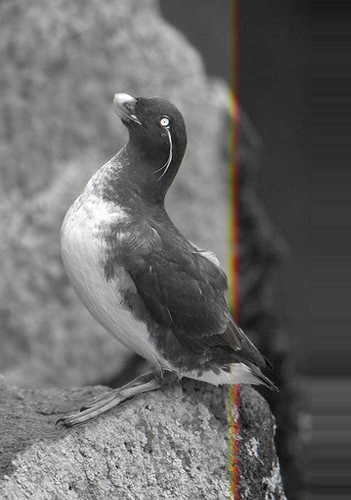

In [66]:
def rotate_image(i):
    return tf.keras.preprocessing.image.random_rotation(
    x=i, rg=15, row_axis=1, col_axis=0, channel_axis=0, fill_mode='nearest',
    cval=0.0, interpolation_order=3)


image_test2 = np.asarray(image_test)
ex2=np.array(rotate_image(image_test2))
pilImage_flipped = Image.fromarray(ex2)
pilImage_flipped

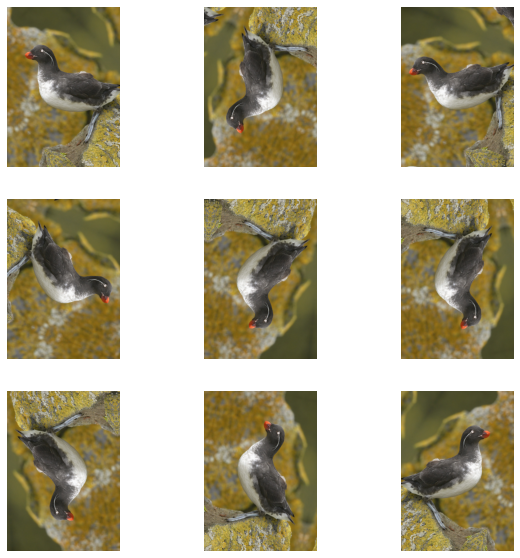

In [68]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

image =image_test2
image = tf.expand_dims(image_test2, 0)
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [134]:
# view complete directory of images

path="./../CUB_200_2011/images/"
img_folder_list = sorted(os.listdir("./../CUB_200_2011/images/"))
img_folders = []
for i in img_folder_list:
    img_folders.append(path + i)
img_folders

['./../CUB_200_2011/images/001.Black_footed_Albatross',
 './../CUB_200_2011/images/002.Laysan_Albatross',
 './../CUB_200_2011/images/003.Sooty_Albatross',
 './../CUB_200_2011/images/004.Groove_billed_Ani',
 './../CUB_200_2011/images/005.Crested_Auklet',
 './../CUB_200_2011/images/006.Least_Auklet',
 './../CUB_200_2011/images/007.Parakeet_Auklet',
 './../CUB_200_2011/images/008.Rhinoceros_Auklet',
 './../CUB_200_2011/images/009.Brewer_Blackbird',
 './../CUB_200_2011/images/010.Red_winged_Blackbird',
 './../CUB_200_2011/images/011.Rusty_Blackbird',
 './../CUB_200_2011/images/012.Yellow_headed_Blackbird',
 './../CUB_200_2011/images/013.Bobolink',
 './../CUB_200_2011/images/014.Indigo_Bunting',
 './../CUB_200_2011/images/015.Lazuli_Bunting',
 './../CUB_200_2011/images/016.Painted_Bunting',
 './../CUB_200_2011/images/017.Cardinal',
 './../CUB_200_2011/images/018.Spotted_Catbird',
 './../CUB_200_2011/images/019.Gray_Catbird',
 './../CUB_200_2011/images/020.Yellow_breasted_Chat',
 './../CUB_2